# 데이터셋
* 감겨 있는 한쪽 눈 사진 617장 (컬러)
* 떠 있는 한쪽 눈 사진 617장 (컬러)
* 정면 혹은 약간 측면을 보며 하품하는 사진 617장 (컬러)
* 정면 혹은 약간 측면을 보며 하품하지 않는 평범한 사진 617장 (컬러)

# 1. CNN 모델 만들기 

대부분의 내용이 Normal.ipynb 파일과 비슷하여 설명셀을 축약하여 적었습니다.

Normal 버전과 다른 내용은 설명하는 셀을 자세히 적고 주석을 첨부하였습니다.

감사합니다.

### Tensorflow 가 없다는 오류가 뜨신다면

<prompt에서 설치하기>
1) Anaconda prompt를 관리자모드로 열어줍니다.

2) 명령어를 입력합니다: 
` conda update --force conda `

3) 명령어를 입력합니다:
` conda install tensorflow `

4) jupyter를 다시 실행합니다.

<br />

<anaconda navigator 에서 설치하기>
1) Anaconda navigator 를 연 뒤, environment 에서 tensorflow를 검색합니다.

2) tensorflow 항목을 선택한 뒤 다운로드 받습니다.

3) jupyter를 다시 실행합니다.

### protobuf downgrade 오류가 뜨신다면

1) Anaconda prompt (관리자모드) 에서 명령어를 입력합니다: `pip uninstall protobuf`

2) Anaconda prompt (관리자모드) 에서 명령어를 입력합니다: `pip install protobuf==3.19.0`

3) jupyter 를 다시 실행합니다.

<br />

 **항상 고생해주셔서 감사합니다!😊**

### CNN 모델을 만들 때 필요한 라이브러리

In [14]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os

import tensorflow as tf #딥러닝 인공지능 기법을 구현하기 쉽게 도와주는 라이브러리
from glob import glob #dataset 의 사진 파일을 list로 불러올 수 있게 도와주는 라이브러리
from tqdm import tqdm #반복문 진행률을 시각화해주는 라이브러리
from PIL import Image #이미지 분석 및 처리를 쉽게할 수 있게 도와주는 라이브러리

from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns

### 1) 데이터셋을 흑백으로 바꾸고 64 * 64 사이즈로 조절하기 

1) glob 은 인자로 전달받은 경로명에서 패턴(이 코드에서는 * 이므로 모든 파일)이 일치하는 파일들을 리스트로 반환합니다.

2) tqdm 은 순회 가능한 객체를 for로 순회할 때, 진행률이 얼마나 되었는지를 보여주는 함수입니다.

3) 이번에는 하품하는 사진과 하품하지 않는 사진도 포함되어 있으므로 전처리할 데이터가 더 많습니다.

In [15]:
#눈 감음: 0, 눈 뜸: 1, 하품: 2, 하품 안함: 3

X = []
Y = []

#눈 감은 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/train/Closed/*')):
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    X.append(temp)
    Y.append(0)  #눈 감은 사진의 라벨은 0으로 설정합니다.

#눈 뜬 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/train/Open/*')): #사진파일을 리스트로 불러옵니다.
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    X.append(temp)
    Y.append(1) #눈 뜬 사진의 라벨은 1로 설정합니다.

#하품하는 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/train/yawn/*')): #사진파일을 리스트로 불러옵니다.
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    X.append(temp)
    Y.append(2) #하품하는사진의 라벨은 2로 설정합니다.

#하품하지 않는 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/train/no_yawn/*')): #사진파일을 리스트로 불러옵니다.
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    X.append(temp)
    Y.append(3) #하품하지 않는 사진의 라벨은 2로 설정합니다.

100%|██████████| 616/616 [00:02<00:00, 215.03it/s]


### 2) 데이터를 0~1 사이의 값으로 만들고, 차원 확장
### 3) Training data 와 Test data 분리하기

Min-Max scailing algorithm: 본래 눈 데이터의 정규분포를 오염시키고 싶지 않아 해당 방법을 선택하였습니다.

이번에는 다중분류모델을 구현해야하므로 to_categorical()을 이용하여 one-hot 인코딩을 진행합니다.

In [16]:
X = (np.array(X) - np.min(X)) / (np.max(X) - np.min(X))
X = X/255.0 #픽셀값은 0~255 사이이므로, 이 값을 0~1로 조절하기 위해 255로 나누기 진행
X = np.expand_dims(X,-1) #가장 끝쪽의 차원을 추가하여 확대합니다. (흑백데이터이므로 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

### 4) CNN Model 생성하기

1) 컨볼루젼 레이어가 2개였을 때 정확도가 90%에서 더 오르지 않아 레이어를 2개 더 추가하였고, 96퍼센트로 성능을 상승시켰습니다.

2) 총 4가지의 카테고리가 있기 때문에 최종 Dense의 unit은 4, 활성함수는 softmax 입니다.

In [17]:
#계층을 선형으로 쌓는 Sequential() 사용, 13주차에서 배운 내용 응용
#Sequential()은 입력층, 은닉층, 출력층 등을 구성하기 위해 사용한다.
classes = 4

model = Sequential([
      Input(shape=(64, 64, 1)), #입력의 크기, 흑백이므로 1

      #출처: keras 공식문서 (https://keras.io/ko/layers/convolutional/)
      #filters: convolution 필터의 개수 == 특성 맵의 개수
      #kernel_size: convolution filter의 크기, 5*5 
      #strides: 필터 윈도우가 움직이는 거리를 지정
      #use_bias: 함수를 데이터에 근사시키기 위해 사용
      #은닉층이므로 ReLU 사용, sigmoid 는 output 이 음수 값으로 나오는 것들을 0에 가깝게 표현하면서
      #weight가 변하지 않는 문제(gradient 소실)로 인해 사용하지 않았습니다.
    
      #1번째 convolution - pooling 레이어 세트
      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(), #입력값을 평균 0, 분산 1로 정규화하여 학습이 잘 일어나도록 돕는 배치 정규화
      MaxPooling2D(strides = 2),
      Dropout(0.3),#과한 학습으로 인한 과적합을 줄이기 위하여 Dropout 실시

      #2번째 convolution - pooling 레이어 세트
      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),
    
      #정확도가 90이 나와 레이어 두 개를 더 쌓는다: 90%에서 96%로 상승되었다.
      Conv2D(filters = 128, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      Conv2D(filters = 128, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      MaxPooling2D(strides = 2),
      Dropout(0.3),
      
      Flatten(), #1차원으로 변환
      # unit: 레이어에서 생성할 뉴런의 수, 출력차원을 결정하고 많을수록 표현력이 높아진다.
      # use_bias: 편향사용여부
      Dense(units  = 256, activation = 'relu', use_bias=False),
      BatchNormalization(),

      Dense(units = 128, use_bias=False, activation = 'relu'),

      Dense(units = 84, use_bias=False, activation = 'relu'),
      BatchNormalization(),
      Dropout(0.3),
        
      #카테고리가 총 4개이므로 unit은 4, softmax 활성함수를 통과시킨다.
      Dense(classes, activation = 'softmax')
  ])
#print(model.summary())

### 5) model 컴파일링하기

binary_crossentropy 가 아닌 categorical_crossentropy를 사용합니다.

In [18]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])

### 6) model 훈련시키기

In [19]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='AdvancedModel.h5', #모델 저장 path 
    save_weights_only=False,#weight가 아닌 전체 모델을 저장
    monitor='val_loss', #손실이 체크포인트 저장 기준
    mode='min', #손실이 가장 낮은 모델을 저장
    verbose =1) #체크포인트 저장 시 로그 메세지 출력
#모델 정확도 증가 X == 저장 X
model.fit(X_train, train_labels, epochs=30, batch_size=32, callbacks=callback)

Epoch 1/30
54/54 [==============================] - ETA: 0s - loss: 0.9312 - acc: 0.6101
Epoch 1: saving model to AdvancedModel.h5
54/54 [==============================] - 6s 80ms/step - loss: 0.9312 - acc: 0.6101
Epoch 2/30
54/54 [==============================] - ETA: 0s - loss: 0.5610 - acc: 0.7312
Epoch 2: saving model to AdvancedModel.h5
54/54 [==============================] - 6s 107ms/step - loss: 0.5610 - acc: 0.7312
Epoch 3/30
54/54 [==============================] - ETA: 0s - loss: 0.4662 - acc: 0.7665
Epoch 3: saving model to AdvancedModel.h5
54/54 [==============================] - 5s 87ms/step - loss: 0.4662 - acc: 0.7665
Epoch 4/30
54/54 [==============================] - ETA: 0s - loss: 0.4506 - acc: 0.7654
Epoch 4: saving model to AdvancedModel.h5
54/54 [==============================] - 5s 97ms/step - loss: 0.4506 - acc: 0.7654
Epoch 5/30
54/54 [==============================] - ETA: 0s - loss: 0.3912 - acc: 0.7908
Epoch 5: saving model to AdvancedModel.h5
54/54 [=====

### 7) model 평가하기 (최대 97%까지 성공하였습니다)

In [20]:
test_loss, test_acc = model.evaluate(X_test, test_labels)
print('Test Accuracy: ', test_acc, '\nTest Loss: ', test_loss)

24/24 [==============================] - 1s 28ms/step - loss: 0.0744 - acc: 0.9717
Test Accuracy:  0.9716598987579346 
Test Loss:  0.07444719225168228


### 8) model로 테스트 이미지 실험해보기

4가지 카테고리별로 확률이 나오는데, 그 중 가장 높은 확률의 인덱스를 구한 뒤 

categories[]에 해당하는 인덱스를 출력하였습니다.

1/1 [==============================] - 0s 205ms/step


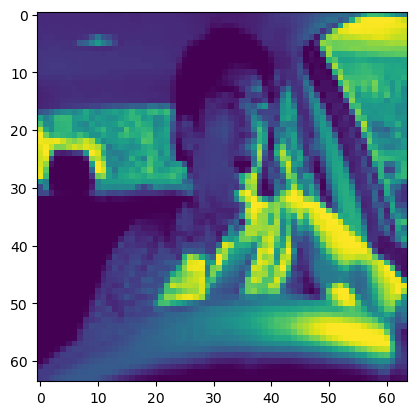

yawn
1/1 [==============================] - 0s 21ms/step


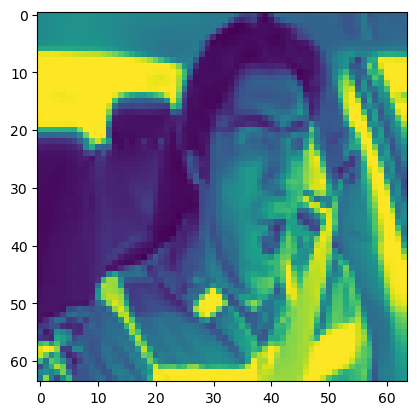

yawn
1/1 [==============================] - 0s 21ms/step


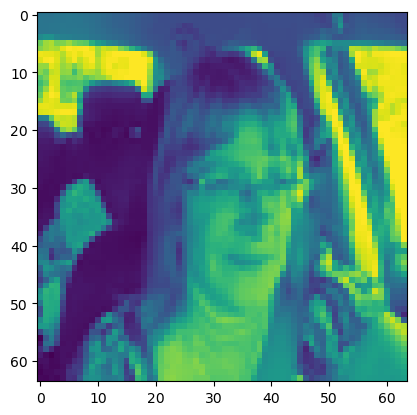

no_yawn
1/1 [==============================] - 0s 23ms/step


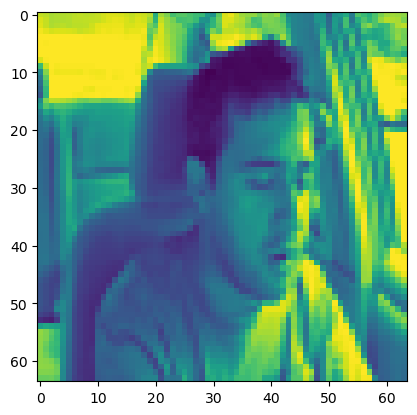

yawn
1/1 [==============================] - 0s 23ms/step


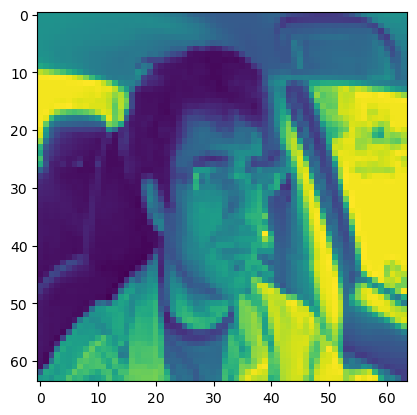

no_yawn
1/1 [==============================] - 0s 20ms/step


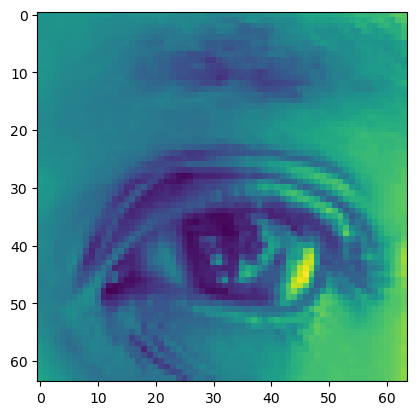

open
1/1 [==============================] - 0s 22ms/step


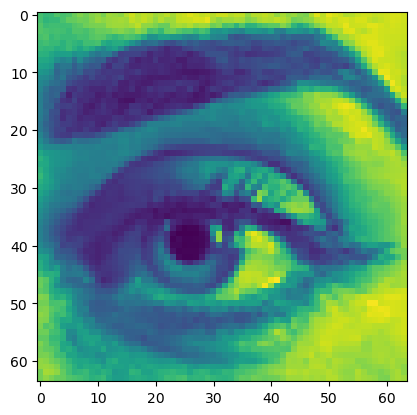

open
1/1 [==============================] - 0s 23ms/step


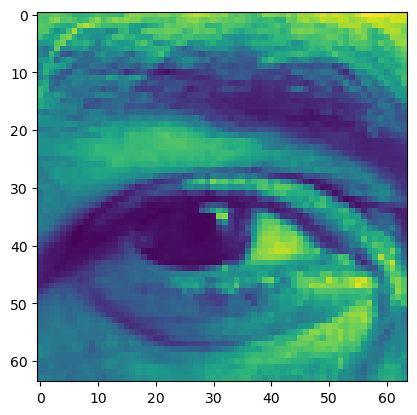

open
1/1 [==============================] - 0s 24ms/step


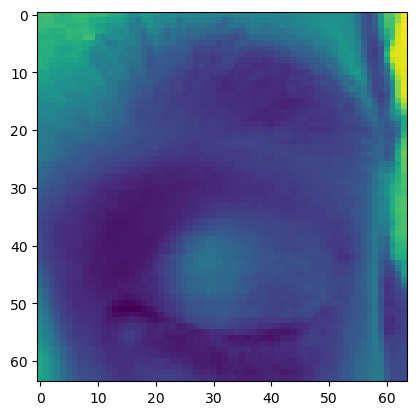

close
1/1 [==============================] - 0s 22ms/step


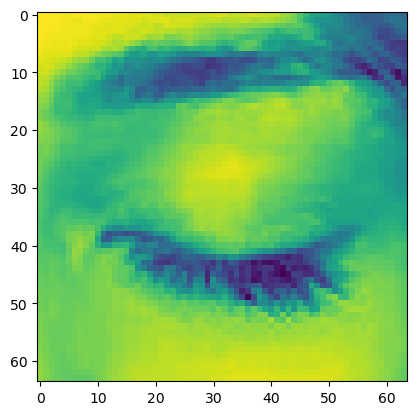

close


In [21]:
categories = ['close', 'open', 'yawn', 'no_yawn']

for img in X_test[0:10]:
    test_img = np.expand_dims(img,0) #배치 차원 추가 (1,64,64,1)
    prediction = model.predict(test_img)
    plt.imshow(img)
    plt.show()
    
    result = [np.argmax(value) for value in prediction]
    print(categories[result[0]])

# 2. 실시간 카메라로 졸음 탐지하기
**1. CNN 모델 만들기** 과정 없이, 함께 제출한 **AdvancedModel.h5** 만 있어도 실행 가능 합니다.

#### 1. cv2 가 없다는 오류가 뜨신다면

아나콘다 프롬프트에 입력합니다: `pip install opencv-python` 

<br />

#### 2. dlib 가 없다는 오류가 뜨신다면
1) http://dlib.net/ 에서 하단의 파란버튼 'Download dlib'를 누른 후, 다운로드합니다. 다운로드 된 압축파일은 아나콘다를 실행했을 때 나오는 기본 폴더에 풀어줍니다.

2) https://cmake.org/download/ 에서 운영체제에 맞는 설치파일을 다운로드 후, 설치합니다.

3) 아나콘다 프롬프트에 입력합니다: `pip install dlib`

<br />

#### 3. torch 가 없다는 오류가 뜨신다면
아나콘다 프롬프트에서 torch를 검색하여 pytorch와 torch를 다운로드 해줍니다. 

<br />

#### 4. imutils 가 없다는 오류가 뜨신다면
아나콘다 프롬프트에 입력합니다: `pip install imutils`

<br />

위의 모든 작업들을 진행하신 뒤에는 jupyter notebook을 재실행하시는 것을 권장드립니다.
감사합니다.

### 졸음 탐지를 할 때 필요한 라이브러리

In [22]:
import cv2 #opencv 라이브러리
import dlib #얼굴탐지를 도와주는 라이브러리
import numpy as np #데이터 전처리를 위해 사용됨
from tensorflow.keras.models import load_model #모델을 불러오기 위해 사용하는 라이브러리
from collections import deque #졸음 탐지용 큐 라이브러리
import threading
import time

### 1) 얼굴 탐지기 (dlib) 와 landmark 탐지기 초기화

In [23]:
# 얼굴 탐지기와 랜드마크 탐지기 초기화
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat') #첨부파일에 함께 넣었습니다.

### 2) 사전에 학습한 모델 불러오기

In [24]:
model = load_model('AdvancedModel.h5')

### 3) 눈 감김 상태를 확인하는 함수

In [25]:
categories = ['close', 'open', 'yawn', 'no_yawn']
# 눈 감김 상태 확인 함수
def check_eye_status(eyes):
    # 입력 이미지 전처리
    img = cv2.resize(eyes, (64, 64))  # 이미지 크기 조절
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 흑백 이미지로 변환
    img = np.array(img) #np.array 화
    img = (np.array(img)-np.min(img))/(np.max(img)-np.min(img)) #min-max scailing
    img = img/255.0 #0~255 사이의 값으로
    img = np.expand_dims(img, axis=-1)  # 차원 확장 (64,64,1) [흑백이미지]
    img = np.expand_dims(img, axis=0)  # 배치 차원 추가 (1,64,64,1) 
    
    # 눈 감김 여부 확인
    prediction = model.predict(img)
    result = [np.argmax(value) for value in prediction]
    return result[0]

# 0일 때 close, 그 이외 open 

### 4) 하품을 했는지, 하지 않았는지 확인하는 함수

In [26]:
def check_yawn_status(face):
    img = cv2.resize(face, (64,64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = np.array(img)
    img = (np.array(img)-np.min(img))/(np.max(img)-np.min(img)) #min-max scailing
    img = img/255.0 #0~255 사이의 값으로
    img = np.expand_dims(img, axis=-1)  # 차원 확장 (64,64,1) [흑백이미지]
    img = np.expand_dims(img, axis=0)  # 배치 차원 추가 (1,64,64,1) 
    
    prediction = model.predict(img)
    result = [np.argmax(value) for value in prediction]
    return result[0]
# 2일 때 하품, 그 이외에 하품 X

### 5) 2초 이상 눈을 감고 있는지 확인하는 함수

In [27]:
def sleep_status(left_eye, right_eye):
    global count
    if left_eye == 0 and right_eye == 0:
        count += 1
        
        if count == 2:
            return 10
    else:
        count = 0
    
    timer = threading.Timer(1, sleep_status, args=(left_eye, right_eye))
    timer.start()

### 6) 카메라 연결 및 탐지

In [28]:
# 카메라 연결
cap = cv2.VideoCapture(0)  # 카메라 장치 번호 (0은 기본 카메라)

# 탐지 시작
while True:
    # 카메라에서 프레임을 읽습니다
    ret, frame = cap.read()
    
    if not ret:
        break
        
    #하품 탐지
    yawn_status = check_yawn_status(frame)
    yawn_label = "yawn" if yawn_status == 2 else "not yawn"
    if yawn_label == 'yawn':
        cv2.putText(frame, yawn_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    else:
        cv2.putText(frame, yawn_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # 얼굴 탐지
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray)
    
    for face in faces:
        # 얼굴에서 랜드마크 탐지
        landmarks = landmark_predictor(gray, face)
        
        # 눈의 상태 확인
        left_eye_status = check_eye_status(frame[(landmarks.part(37).y)-10:(landmarks.part(41).y)+10, (landmarks.part(36).x)-10:(landmarks.part(39).x)+10])
        right_eye_status = check_eye_status(frame[(landmarks.part(43).y)-10:(landmarks.part(47).y)+10, (landmarks.part(42).x)-10:(landmarks.part(45).x)+10])
        
        #졸음 상태, 2초 동안 눈을 감고 있으면 wake up!
        sleepy = sleep_status(left_eye_status, right_eye_status)
        sleepy_label = 'Wake up!' if sleepy == 10 else 'Good'
        if sleepy_label == 'Wake up!':
            cv2.putText(frame, sleepy_label, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        else:
            cv2.putText(frame, sleepy_label, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
        # 눈 감김 상태 출력
        left_eye_label = 'Closed Eye' if left_eye_status == 0 else 'Open Eye'
        right_eye_label = 'Closed Eye' if right_eye_status == 0 else 'Open Eye'
        cv2.putText(frame, left_eye_label, (landmarks.part(36).x, landmarks.part(36).y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(frame, right_eye_label, (landmarks.part(42).x, landmarks.part(42).y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # 결과 영상 표시
    cv2.imshow('Eye Detection', frame)
    
    # q 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 리소스 해제
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 30ms/step


### * 카메라에 오류가 생겼다면 하단의 셀을 실행해주세요.

In [29]:
# 카메라에 오류가 생겼을 경우 이 셀을 강제로 실행해주세요.
# 리소스 해제
cap.release()
cv2.destroyAllWindows()